### Preamble:

These scenarios are based on setting a range of DOY for the snowmelt season occures and for each of those days, pulling a daily snowmelt rate from a distribution of snowmelt rates based on observations, but enlarged by 10% and shifted forward (earlier in the year) 10 days to allow for more rapid snowmelt rates and a wider range of daily snowmelt rates. Once the timeseries of snowmelt rates is generates the average snowmelt rate is computed and then the timeseries is scaled to the desired average snowmelt rate dictated by the length and timing of the ablation season and peak swe for the scenario.

In [1]:
import rhessys.utilities as rut
from matplotlib.patches import Polygon
from statsmodels.api import formula as sm
import rhessys.snowmelt_experiment as smex

In [2]:
method='method7'
site='Nr1'
smexp='smex7'

In [3]:
dat = pd.read_pickle('../data/niwot_new.pcl')

In [4]:
dat.describe()

/Users/barnhatb/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Tave,Tmax,Tmin,AccumP,P,Psnowadj,SD,SWE,snowmelt,wateryear,dowy
count,9355.000000,9284.000000,9342.000000,12697.000000,12696.000000,12696.000000,3544.000000,12697.000000,12696.00000,12698.000000,12698.000000
mean,1.921956,9.392514,-4.113198,392.872332,2.324669,2.717076,41.432844,108.701583,0.00000,1997.883446,182.184911
std,7.974632,9.809261,7.460082,268.327379,4.913844,5.189074,46.885367,128.419151,6.63072,10.036633,105.153659
min,-25.000000,-22.800000,-47.700000,0.000000,0.000000,0.000000,0.000000,0.000000,-73.00000,1980.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989.000000,91.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998.000000,182.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,273.000000
max,19.700000,46.700000,13.800000,1059.000000,76.000000,76.000000,467.000000,536.000000,59.00000,2015.000000,366.000000


In [5]:
dat.loc[dat.SWE<5,'SWE'] = 0.
dat.SWE /= 1000. # mm > m

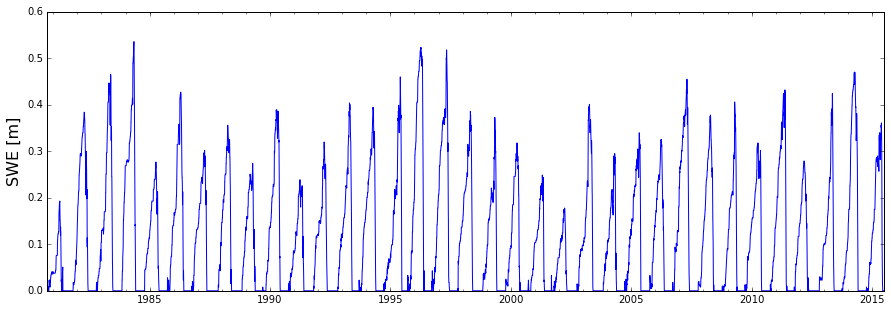

In [6]:
plt.figure(figsize=(15,5))
dat.SWE.plot()
plt.ylabel('SWE [m]', fontsize=16)

In [7]:
stats = pd.DataFrame()
stats['wateryear'] = dat.wateryear.unique()[1:]

for wy in dat.wateryear.unique()[1:]:
    tmp = dat.loc[dat.wateryear == wy]
    
    dopeakswe = tmp.SWE.argmax()
    peakswe = tmp.SWE.max()
    
    stats.loc[stats.wateryear==wy,'doaccum'] = tmp.loc['%s-10-01'%(wy-1):dopeakswe].SWE.argmin()
    stats.loc[stats.wateryear==wy,'dosnowfree'] = tmp.loc[dopeakswe:'%s-09-30'%wy].SWE.argmin()
    stats.loc[stats.wateryear==wy,'dopeakswe'] = dopeakswe
    stats.loc[stats.wateryear==wy,'peakswe'] = peakswe
    

In [8]:
def compute_dowy(dt):
    year = dt.year
    month = dt.month
    day = dt.day
    wy = rut.wateryear(dt)
    
    timedelta = dt-pd.datetime.strptime('%s-10-1'%(wy-1),'%Y-%m-%d')   
    
    return timedelta.days

In [9]:
stats['dowy_accum'] = stats.doaccum.map(compute_dowy)
stats['dowy_snowfree'] = stats.dosnowfree.map(compute_dowy)
stats['dowy_peakswe'] = stats.dopeakswe.map(compute_dowy)

In [10]:
stats.to_pickle('../data/Nr1_swe_stats.pcl')

In [11]:
stats['SMR'] = stats.peakswe/(stats.dowy_snowfree-stats.dowy_peakswe) # compute wateryear average snowmelt rate

In [12]:
stats.head()

,wateryear,doaccum,dosnowfree,dopeakswe,peakswe,dowy_accum,dowy_snowfree,dowy_peakswe,SMR
0,1981,1980-10-01,1981-05-05,1981-04-09,0.193,0,216,190,0.007423
1,1982,1981-10-01,1982-06-11,1982-04-13,0.384,0,253,194,0.006508
2,1983,1982-10-01,1983-06-23,1983-05-21,0.465,0,265,232,0.014091
3,1984,1983-10-01,1984-06-02,1984-05-06,0.536,0,245,218,0.019852
4,1985,1984-10-01,1985-05-22,1985-04-05,0.277,0,233,186,0.005894


In [13]:
stats.tail()

,wateryear,doaccum,dosnowfree,dopeakswe,peakswe,dowy_accum,dowy_snowfree,dowy_peakswe,SMR
30,2011,2010-10-01,2011-06-13,2011-05-22,0.432,0,255,233,0.019636
31,2012,2011-10-01,2012-05-06,2012-03-04,0.279,0,218,155,0.004429
32,2013,2012-10-01,2013-06-06,2013-05-11,0.424,0,248,222,0.016308
33,2014,2013-10-01,2014-06-05,2014-04-09,0.470,0,247,190,0.008246
34,2015,2014-10-01,2015-06-12,2015-05-25,0.361,0,254,236,0.020056


In [17]:
round(stats.SMR.mean()*1000,2)

10.05

In [15]:
round(stats.dowy_peakswe.mean())

200.0

### Generate the SWE Triangles

In [13]:
peakswe = stats.peakswe.mean()
DOAS = stats.dowy_accum.mean()
DONS = stats.dowy_snowfree.mean()
DOWYpeakSWE = stats.dowy_peakswe.mean()

peakswe90 = np.percentile(stats.peakswe,90)
DOAS90 = np.percentile(stats.dowy_accum,90)
DONS90 = np.percentile(stats.dowy_snowfree,90)
DOWYpeakSWE90 = np.percentile(stats.dowy_peakswe,90)

peakswe10 = np.percentile(stats.peakswe,10)
DOAS10 = np.percentile(stats.dowy_accum,10)
DONS10 = np.percentile(stats.dowy_snowfree,10)
DOWYpeakSWE10 = np.percentile(stats.dowy_peakswe,10)

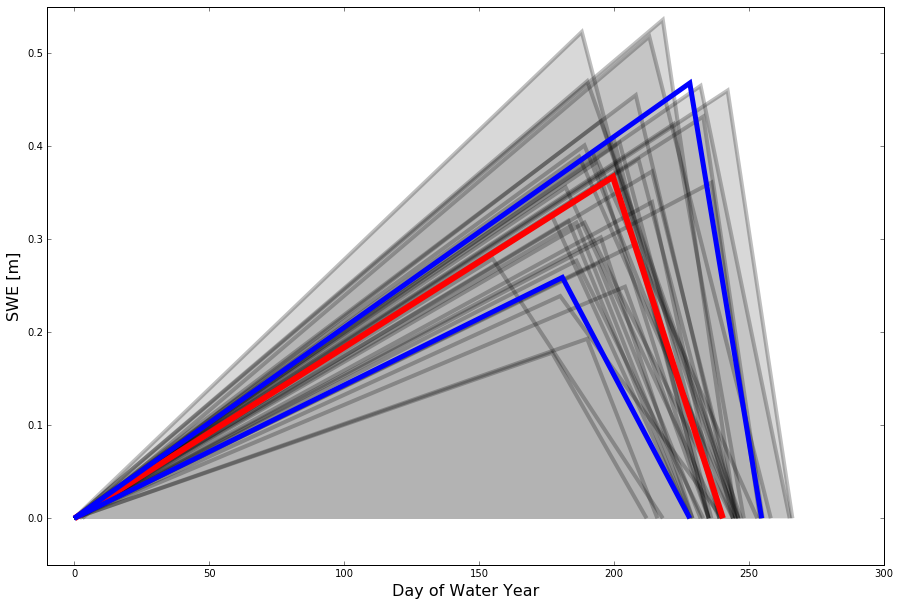

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for wy in np.unique(stats.index):
    
    x1 = stats.loc[stats.index==wy,'dowy_accum'].as_matrix()[0]
    x2 = stats.loc[stats.index==wy,'dowy_snowfree'].as_matrix()[0]
    x3 = stats.loc[stats.index==wy,'dowy_peakswe'].as_matrix()[0]
    y3 = stats.loc[stats.index==wy,'peakswe'].as_matrix()[0]
    
    pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
    p = Polygon(pts, closed=False, alpha = 0.5,edgecolor='none',facecolor='0.7')
    ax.add_patch(p)
    
for wy in np.unique(stats.index):
    
    x1 = stats.loc[stats.index==wy,'dowy_accum'].as_matrix()[0]
    x2 = stats.loc[stats.index==wy,'dowy_snowfree'].as_matrix()[0]
    x3 = stats.loc[stats.index==wy,'dowy_peakswe'].as_matrix()[0]
    y3 = stats.loc[stats.index==wy,'peakswe'].as_matrix()[0]
    
    pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
    p = Polygon(pts, closed=False, alpha = 0.25,edgecolor='k',facecolor='none',lw=4)
    ax.add_patch(p)

x1 = DOAS
x2 = DONS
x3 = DOWYpeakSWE
y3 = peakswe

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='r',facecolor='none',lw=6)
ax.add_patch(p)

x1 = DOAS10
x2 = DONS90
x3 = DOWYpeakSWE90
y3 = peakswe90

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='b',facecolor='none',lw=5)
ax.add_patch(p)

x1 = DOAS90
x2 = DONS10
x3 = DOWYpeakSWE10
y3 = peakswe10

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='b',facecolor='none',lw=5)
ax.add_patch(p)    

ax.set_xlim(-10,300)
ax.set_ylim(-.05,.55)
plt.xlabel('Day of Water Year', fontsize = 16)
plt.ylabel('SWE [m]', fontsize=16)

In [15]:
dat.columns

Index([u'Tave', u'Tmax', u'Tmin', u'AccumP', u'P', u'Psnowadj', u'SD', u'SWE',
       u'snowmelt', u'wateryear', u'dowy'],
      dtype='object')

In [16]:
dates = [] # preallocate actual dates
snowmelts = [] # preallocate snowmelt rates
DOAS = [] # preallocate date of ablation season array

for wy in np.unique(stats.wateryear): # loop through each water year and extract each snowmelt season
    
    strt = stats.loc[stats.wateryear==wy,'dopeakswe'].as_matrix()[0] # get the date of peak SWE
    nd = stats.loc[stats.wateryear==wy,'dosnowfree'].as_matrix()[0] # get the date of no snow
    
    smelt = list(dat.loc[strt:nd,'snowmelt'])
    
    snowmelts.extend(list(smelt)) # pull out the snowmelts
    DOAS.extend(list(np.arange(1,len(smelt)+1))) # create an array of ablation season days
    dates.extend(list(pd.date_range(strt,nd,freq='D'))) # create an array of actual days

In [17]:
# generate an array snowmelt events and the day of the water year that they occured on.
AS = pd.DataFrame({'snowmelt':snowmelts,'DOAS':DOAS,'date':dates})
AS['DOWY'] = AS.date.map(rut.DOWY)
AS['DOWY2'] = AS.DOWY**2

/Users/barnhatb/Dropbox/python/bin/rhessys/utilities.py:83: FutureWarning: pandas.core.datetools.datetime is deprecated. Please use datetime.datetime instead.
  ref = pd.datetools.datetime(int(wy)-1,10,1) # set the beginning of the water year


In [18]:
AS = AS.loc[AS.snowmelt>=0].copy()

In [19]:
AS.to_pickle('./data/NR1_ablation_season_data.pcl')

In [19]:
mod = sm.ols('snowmelt ~ DOWY +1', AS).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:               snowmelt   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     240.9
Date:                Mon, 05 Dec 2016   Prob (F-statistic):           5.65e-50
Time:                        14:47:51   Log-Likelihood:                -4812.7
No. Observations:                1304   AIC:                             9629.
Df Residuals:                    1302   BIC:                             9640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -35.4254      3.001    -11.805      0.0

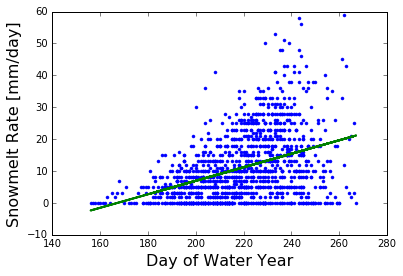

In [20]:
plt.plot(AS.DOWY,AS.snowmelt,'.')
plt.xlabel('Day of Water Year', fontsize=16)
plt.ylabel('Snowmelt Rate [mm/day]', fontsize=16)
plt.plot(AS.DOWY,mod.fittedvalues,'-', lw=2)
plt.savefig('./figures/DOWY_SMR_model.png', dpi = 300, bbox_inches='tight')

In [21]:
meanPeakSWE = round(stats.peakswe.mean(),3)
PeakSWEstd = round(stats.peakswe.std(),3)

meanDOWYpeakSWE = round(stats.dowy_peakswe.mean(),0)
DOWYpeakSWEstd = round(stats.dowy_peakswe.std(),0)

minSMR = round(stats.SMR.min(),3)
maxSMR = round(stats.SMR.max(),3)

print 'mean peak SWE: %s +/-%s'%(meanPeakSWE,PeakSWEstd)
print 'mean DOWY peak SWE: %s +/-%s'%(meanDOWYpeakSWE,DOWYpeakSWEstd)
print 'min. SMR: %s, max. SMR: %s'%(minSMR,maxSMR)

mean peak SWE: 0.367 +/-0.089
mean DOWY peak SWE: 200.0 +/-19.0
min. SMR: 0.004, max. SMR: 0.02


In [22]:
# draw n parameters from uniform distributions and put them in a data frame
n=200000
m=10000
mult = 2
TpeakSWEs = np.round(np.random.uniform(low=meanDOWYpeakSWE-(mult*DOWYpeakSWEstd),high=meanDOWYpeakSWE+(mult*DOWYpeakSWEstd),size=n))
peakswe = np.random.uniform(low=meanPeakSWE-(mult*PeakSWEstd),high=meanPeakSWE+(mult*PeakSWEstd),size=n)
SMR = np.random.uniform(low=minSMR,high=maxSMR,size=n)

params = pd.DataFrame({'TpeakSWE':TpeakSWEs,'SMR':SMR,'peakSWE':peakswe})

In [23]:
params['ablSeas'] = np.ceil(params['peakSWE']/params['SMR'])
params['Tnosnow'] = params['TpeakSWE'] + params['ablSeas']

In [24]:
params.loc[params.Tnosnow>318] = np.NaN # remove runs that go past mid august
params.loc[params.TpeakSWE<=14] = np.NaN # remove runs that start before mid october 
params.loc[params.peakSWE<=0] = np.NaN # remove runs with no snow
params.loc[params.SMR>params.peakSWE] = np.NaN
params.dropna(inplace=True)

In [25]:
params.reset_index(inplace=True)
del params['index']

In [26]:
n = len(params)
params = params.ix[list(np.random.randint(0,high=n,size=m))].copy()
#params = params.ix[list(np.random.random_integers(0,high = n,size = m))].copy()

In [27]:
params.shape

(10000, 5)

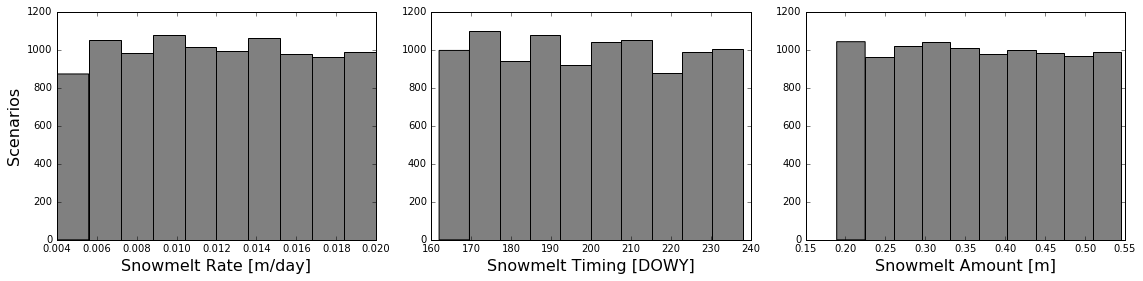

In [28]:
params[['SMR','TpeakSWE','peakSWE']].hist(figsize=(16,4),layout=(1,3),grid=False, facecolor='0.5');
p = plt.gcf()
axes = p.get_axes()
xlabels = ['Snowmelt Rate [m/day]','Snowmelt Timing [DOWY]', 'Snowmelt Amount [m]']
for ax,lab in zip(axes,xlabels):
    ax.set_title('')
    ax.set_xlabel(lab, fontsize = 16)
axes[0].set_ylabel('Scenarios', fontsize=16)
plt.tight_layout()
plt.savefig('./figures/scenario_design_example.png',dpi=300,bbox_inches='tight')

In [29]:
# calculate a bunch of things
params['ref'] = 2010 # add a reference water year
params['date_ONS'] = params.apply(smex.DONS2cal, axis=1) # compute the day of water year for no snow
params['DOAS'] = 15 # compute the day of water year for the beginning of accumulation
params['date_AS'] = params.apply(smex.DOAS2cal, axis=1) # compute the date for the beginning of accumulation
params['idx'] = np.arange(0,len(params)) # add an index column
params['date_peakSWE']=params.apply(smex.DOPEAKSWE2cal,axis=1)

/Users/barnhatb/Dropbox/python/bin/rhessys/snowmelt_experiment.py:20: FutureWarning: pandas.core.datetools.timedelta is deprecated. Please use datetime.timedelta instead.
  td = pd.datetools.timedelta(x.Tnosnow-1)
/Users/barnhatb/Dropbox/python/bin/rhessys/snowmelt_experiment.py:28: FutureWarning: pandas.core.datetools.timedelta is deprecated. Please use datetime.timedelta instead.
  td = pd.datetools.timedelta(x.DOAS-1)
/Users/barnhatb/Dropbox/python/bin/rhessys/snowmelt_experiment.py:12: FutureWarning: pandas.core.datetools.timedelta is deprecated. Please use datetime.timedelta instead.
  td = pd.datetools.timedelta(x.TpeakSWE-1)


In [30]:
params.describe()

,SMR,TpeakSWE,peakSWE,ablSeas,Tnosnow,ref,DOAS,idx
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0,10000.0,10000.00000
mean,0.012044,199.562300,0.365668,36.59880,236.161100,2010.0,15.0,4999.50000
std,0.004544,21.969465,0.102734,19.75904,28.929837,0.0,0.0,2886.89568
min,0.004002,162.000000,0.189063,10.00000,173.000000,2010.0,15.0,0.00000
25%,0.008166,180.000000,0.277546,22.00000,214.000000,2010.0,15.0,2499.75000
50%,0.011996,199.000000,0.364427,31.00000,235.000000,2010.0,15.0,4999.50000
75%,0.015966,218.000000,0.453432,46.00000,256.000000,2010.0,15.0,7499.25000
max,0.020000,238.000000,0.544985,135.00000,318.000000,2010.0,15.0,9999.00000


In [31]:
params.to_pickle('./data/params_%s_smex_%s.pcl'%(site,method)) # save 

In [32]:
def genSMcurve(x):
    PSWE = x.peakSWE # new peak SWE [m]
    SMR = x.SMR # new snowmelt rate [m/d]
    tPeakSWE = x.TpeakSWE # new day of water year of peak SWE [DOWY]
    tNoSnow = x.Tnosnow # the day of water year of no snow
    ablSeas = x.ablSeas # length of the ablation season
    
    # Generate a list of DOWY
    res = pd.DataFrame({'dowy':np.arange(tPeakSWE,tNoSnow)}) # create a data frame
    
    min_SMR = float((mod.params['DOWY']*tPeakSWE))
    max_SMR = float((mod.params['DOWY']*tNoSnow))
    
    #print min_SMR
    #print max_SMR
    
    if min_SMR < 0: # if the SMR is less than zero, set it to zero
        min_SMR = 0
    
    res['sm'] = np.linspace(min_SMR,max_SMR,num=len(res))
    
    meanSMR = np.mean(res.sm) # compute the mean snowmelt rate [m/d]
    diff = SMR/meanSMR # compute the ratio [1]
    res['sm'] *= diff # scale the snowmelt curve to match the correct one
    
    res['accum_sm'] = res.sm.cumsum() # generate accumulated snowmelt
    res['SWE'] = PSWE
    res['SWE'] = res.SWE-res.accum_sm
    
    
    # handle the dates
    res['ref'] = 2010 # create a reference year column
    res['date'] = res.apply(smex.DOWY2cal,axis=1)
    res['year'] = res.date.map(smex.getyear)
    res['month'] = res.date.map(smex.getmonth)
    res['day'] = res.date.map(smex.getday)
    res['hour'] = 1. # create an hour column
    
    # create an array for export
    
    years = res.year.as_matrix()
    months = res.month.as_matrix()
    days = res.day.as_matrix()
    hours = res.hour.as_matrix()
    sm = res.sm.as_matrix()
    
    # reshape the arrays
    years = np.reshape(years,[len(years),1]) 
    months = np.reshape(months,[len(months),1]) 
    days = np.reshape(days,[len(days),1]) 
    hours = np.reshape(hours,[len(hours),1]) 
    sm = np.reshape(sm,[len(sm),1]) 
    
    out = np.concatenate((years,months,days,hours,sm),axis=1) # concat the arrays
    
    filenum = int(x.idx)
    
    #plt.plot(res.dowy,res.SWE)
    #plt.xlim(0,365)
    #plt.savefig('/Volumes/data/RHESSys_out/Nwt/%s_pngs/%s_%s.png'%(smexp,smexp,filenum))
    #plt.clf()
    
    np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/hourly/scen_%s.snow_melt_input'%(smexp,filenum),out,fmt='%i %i %i %i %10.8f',
              comments='',header=str(len(years)))

In [33]:
# make a function that repeats the weather data for 20 years 

def genrain(x):
    
    strt = x.date_peakSWE # beginning of snowmelt
    strt2 = x.date_AS # beginning of the snow season
    nd = x.date_ONS-pd.datetools.timedelta(1) # end of the snow season
    filenum = int(x.idx)

    year_1 = crn.loc['2009-10-1':'2010-09-30'].copy() # subset the P, units should be m
    year_end = crn.loc['2009-10-1':'2010-10-15'].copy().reset_index()
    MAP = crn.loc['2009-10-1':'2010-09-30'].copy()
    nonleap = crn.loc['2009-10-1':'2010-09-30'].copy().reset_index()
    leap = crn.loc['2009-10-1':'2010-10-01'].copy().reset_index()

    nonleap.reset_index(inplace=True) # remove index
    leap.reset_index(inplace=True) # remove index

    year_1.loc[str(strt):str(nd),'P'] = 0. # zero the rain for peak swe to DONS, so it builds a snowpack 
    year_1.reset_index(inplace=True)
    forcing = pd.concat([year_1,nonleap,leap,nonleap,nonleap,nonleap,leap,nonleap,nonleap,year_end],axis=0)
    forcing.index = pd.DatetimeIndex(pd.date_range('2009-10-1',periods=len(forcing),freq='D'))

    MAP.loc[str(strt2):str(nd),'P'] = 0. # zero the rain for the snow season, add in peak SWE to get total precip
    MAP.reset_index(inplace=True)
    forcing_exp = pd.concat([MAP,nonleap,leap,nonleap,nonleap,nonleap,leap,nonleap,nonleap,year_end],axis=0)
    forcing_exp.index = pd.DatetimeIndex(pd.date_range('2009-10-1',periods=len(forcing_exp),freq='D'))
    
    header = '2009 10 1'
    np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/daily/boulder_crn_corr_%s.rain'%(smexp,filenum),
               forcing.P,comments='',header=header,fmt='%10.8f')
    
    if x.temp_out == True: # output only one set of climate data
        np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/daily/boulder_crn_corr.tmin'%(smexp),
                   forcing.Tmin,comments='',header=header,fmt='%10.8f')
        np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/daily/boulder_crn_corr.tmax'%(smexp),
                   forcing.Tmax,comments='',header=header,fmt='%10.8f')
        np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/daily/boulder_crn_corr.tavg'%(smexp),
                   forcing.Tave,comments='',header=header,fmt='%10.8f')
        np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/daily/boulder_crn_corr.daytime_rain_duration'%(smexp),
                   forcing.rain_duration,comments='',header=header,fmt='%10.8f')
    
    Pex = forcing_exp.P.sum(axis=0) # rain during the first water year, add peak SWE to get experiment WY P

    return Pex  # return the total rain for the experimental period


In [35]:
tmp = pd.read_pickle('../data/crn_corr.pcl')
tmp['rain_duration'] = (tmp.P*0.6890) + 1.0826
tmp.loc[tmp.rain_duration>24,'rain_duration'] = 24
crn = pd.DataFrame(tmp[['P','Tmax','Tmin','Tave_mod','rain_duration']])

In [36]:
crn.columns = ['P','Tmax','Tmin','Tave','rain_duration']
crn.P *= 0.001 # mm to m

In [37]:
params['temp_out'] = False
params.loc[params.idx==0,'temp_out'] = True

In [38]:
params.apply(genSMcurve,axis=1);
print 'Done with snowmelt scenarios'
params['MAP'] = params.apply(genrain,axis=1)
print 'Done with rain timeseries'

/Users/barnhatb/Dropbox/python/bin/rhessys/snowmelt_experiment.py:4: FutureWarning: pandas.core.datetools.timedelta is deprecated. Please use datetime.timedelta instead.
  td = pd.datetools.timedelta(x.dowy-1)


Done with snowmelt scenarios


/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pandas.core.datetools.timedelta is deprecated. Please use datetime.timedelta instead.


Done with rain timeseries


In [39]:
params.head()

,SMR,TpeakSWE,peakSWE,ablSeas,Tnosnow,ref,date_ONS,DOAS,date_AS,idx,date_peakSWE,temp_out,MAP
114927,0.007447,180.0,0.413660,56.0,236.0,2010,2010-05-24,15,2009-10-15,0,2010-03-29,True,6.165935
90071,0.017967,202.0,0.423372,24.0,226.0,2010,2010-05-14,15,2009-10-15,1,2010-04-20,False,6.178629
55307,0.014164,236.0,0.470056,34.0,270.0,2010,2010-06-27,15,2009-10-15,2,2010-05-24,False,6.099164
13817,0.013006,198.0,0.478686,37.0,235.0,2010,2010-05-23,15,2009-10-15,3,2010-04-16,False,6.165935
71193,0.014850,235.0,0.410855,28.0,263.0,2010,2010-06-20,15,2009-10-15,4,2010-05-23,False,6.099164


In [40]:
params.to_pickle('./data/params_%s_smex_%s.pcl'%(site,method)) # save 

In [41]:
def date2DOY(s):
    return int(pd.datetime.strftime(s,'%j'))

In [42]:
params['DOY_peakSWE'] = params.date_peakSWE.map(date2DOY)

In [43]:
np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/%s/%s_%s_DOY_peakSWE.txt'%(smexp,site,smexp),params.DOY_peakSWE.as_matrix(),fmt='%d')

### Visualize The Snowmelt Scenarios

In [81]:
data = pd.read_pickle('./data/params_%s_smex_%s.pcl'%(site,method))

In [82]:
data.columns

Index([u'Tnosnow', u'TpeakSWE', u'peakSWE', u'SMR', u'ref', u'date_ONS',
       u'DOAS', u'date_AS', u'idx', u'date_peakSWE', u'MAP'],
      dtype='object')

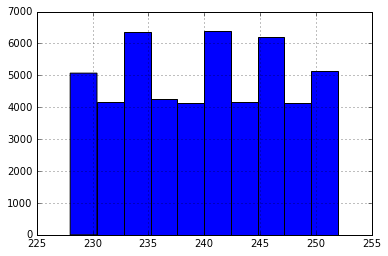

In [47]:
params.Tnosnow.hist()

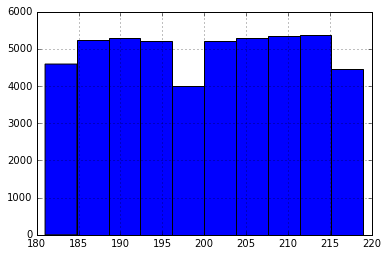

In [48]:
params.TpeakSWE.hist()

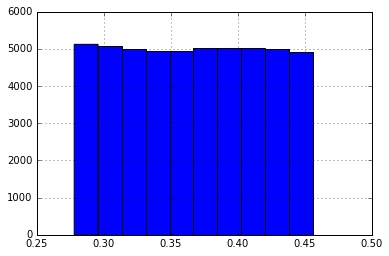

In [49]:
params.peakSWE.hist()

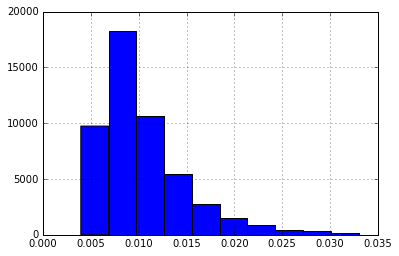

In [50]:
params.SMR.hist()